# T√ºrkiye Otomotiv Satƒ±≈ü Adet Tahmini

Bu notebook'ta adƒ±m adƒ±m:
1. Veri analizi yaptƒ±m
2. Time Series ile baƒüƒ±msƒ±z deƒüi≈ükenleri tahmin edip kaydettim.
3. √áoklu doƒürusal regresyon modeli kurup kaydettim
4. Haz'22 - Haz'23 d√∂nemini tahmin ettim.


## 1. Gerekli K√ºt√ºphaneler


In [1]:
# Temel k√ºt√ºphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Time Series i√ßin
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Machine Learning i√ßin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Ayarlar
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("‚úÖ K√ºt√ºphaneler y√ºklendi")


‚úÖ K√ºt√ºphaneler y√ºklendi


/Users/ecedalpolat/Desktop/linkteracasesolving/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2. Veri Y√ºkleme ve ƒ∞nceleme


In [2]:
# Veriyi y√ºkle
df = pd.read_excel('data/raw/Veri-Seti.xlsx')
print(f"Veri ≈üekli: {df.shape}")
print(f"S√ºtunlar: {df.columns.tolist()}")
df.head()


Veri ≈üekli: (162, 6)
S√ºtunlar: ['Date', 'Otomotiv Satis', 'OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']


Date  Otomotiv Satis  OTV Orani     Faiz    EUR/TL  Kredi Stok
0 2010-01-01         20095.0       37.0  13.1820  2.107385  341244.126
1 2010-02-01         31172.0       37.0  13.2725  2.073890  351940.949
2 2010-03-01         51769.0       37.0  12.7275  2.085522  361307.320
3 2010-04-01         54946.0       37.0  12.0120  2.009010  373575.340
4 2010-05-01         59377.0       37.0  11.7400  1.948870  387708.051

In [3]:
# Tarih formatƒ±nƒ± d√ºzenle ve eksik deƒüerleri incele
df['Date'] = pd.to_datetime(df['Date'])

print(f"Tarih aralƒ±ƒüƒ±: {df['Date'].min()} - {df['Date'].max()}")
print(f"Toplam ay sayƒ±sƒ±: {len(df)}")

print("\n=== EKSƒ∞K DEƒûERLER ===")
missing_info = df.isnull().sum()
missing_pct = (missing_info / len(df)) * 100
missing_df = pd.DataFrame({'Eksik_Sayƒ±': missing_info, 'Eksik_%': missing_pct})
print(missing_df)


Tarih aralƒ±ƒüƒ±: 2010-01-01 00:00:00 - 2023-06-01 00:00:00
Toplam ay sayƒ±sƒ±: 162

=== EKSƒ∞K DEƒûERLER ===
                Eksik_Sayƒ±   Eksik_%
Date                     0  0.000000
Otomotiv Satis          13  8.024691
OTV Orani               13  8.024691
Faiz                    13  8.024691
EUR/TL                  13  8.024691
Kredi Stok              13  8.024691


## 3. Time Series Analizi 

**Time Series (Zaman Serisi)**
- Zamana g√∂re sƒ±ralanmƒ±≈ü veri noktalarƒ±
- Trend, mevsimsellik, d√∂ng√º ve rastgele bile≈üenler i√ßerir
- Ge√ßmi≈ü verilerden gelecek tahminleri yapar

**ARIMA Modeli**
- **AR (AutoRegressive)**: Ge√ßmi≈ü deƒüerlerin bug√ºnk√º deƒüeri etkilemesi
- **I (Integrated)**: Veriyi duraƒüan hale getirmek i√ßin fark alma
- **MA (Moving Average)**: Ge√ßmi≈ü hatalarƒ±n bug√ºnk√º deƒüeri etkilemesi

**ARIMA(p,d,q) Parametreleri:**
- **p**: AR parametresi (ka√ß ge√ßmi≈ü deƒüer kullanƒ±lacak)
- **d**: Fark alma sayƒ±sƒ± (duraƒüanlƒ±k i√ßin)
- **q**: MA parametresi (ka√ß ge√ßmi≈ü hata kullanƒ±lacak)


Tam veri sayƒ±sƒ±: 149
Son tam veri tarihi: 2022-05-01 00:00:00


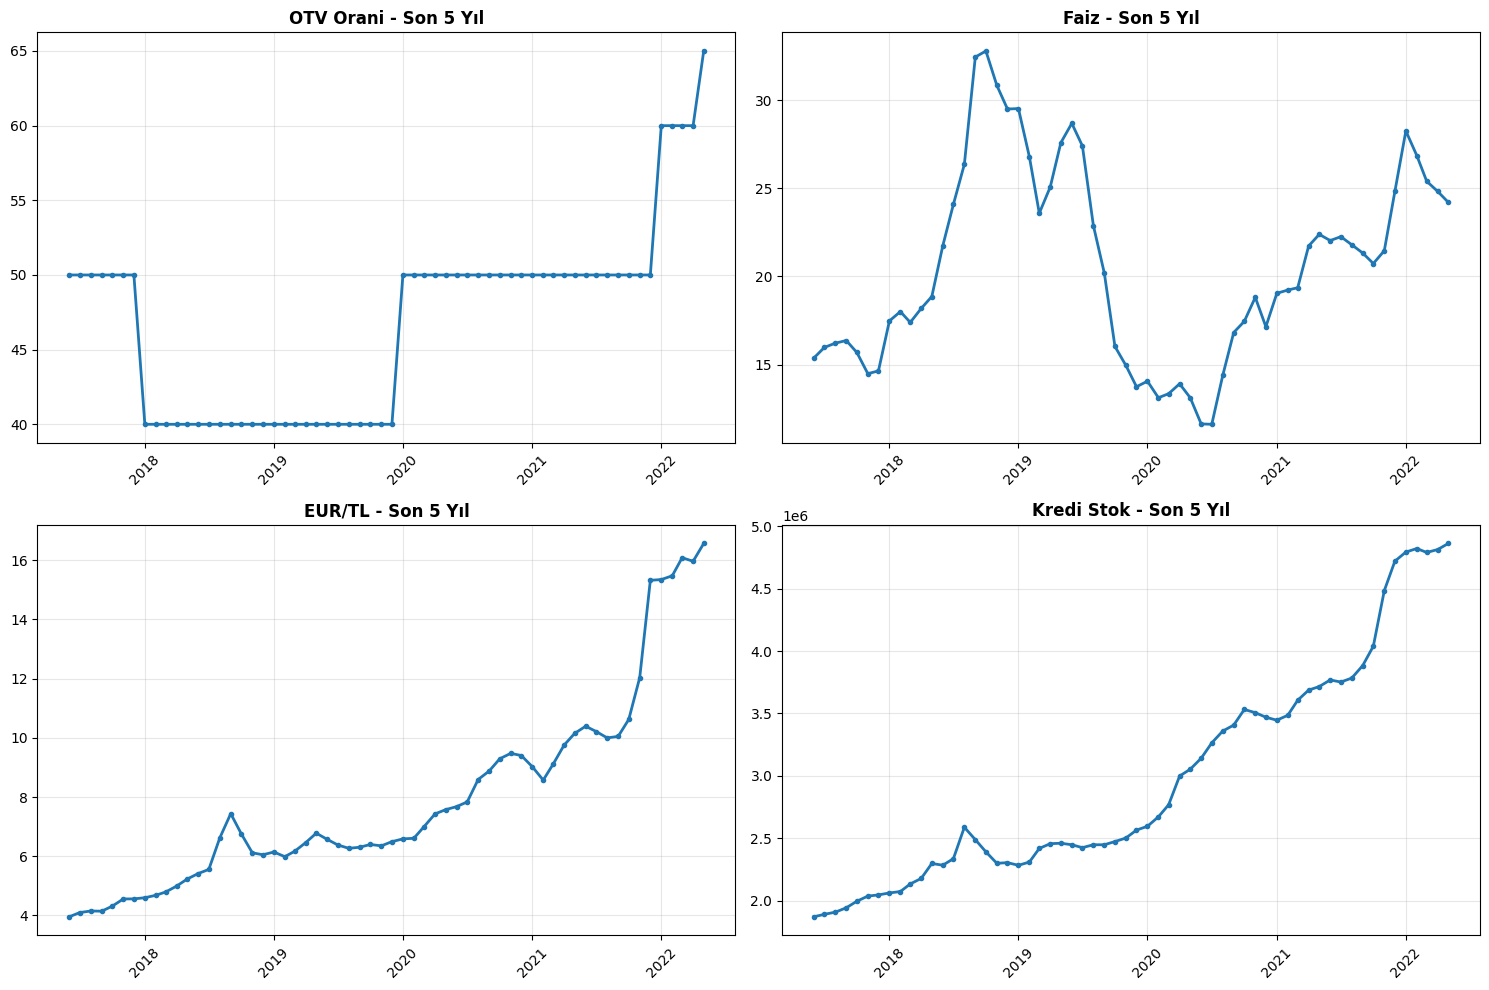

üîç Grafiklere bakarak:
- Hangi deƒüi≈ükenler trend g√∂steriyor?
- Hangileri dalgalƒ±/volatil?
- Mevsimsellik var mƒ±?


In [4]:
# √ñnce veriyi g√∂rselle≈ütirerek trend ve pattern'leri anlayalƒ±m
complete_data = df.dropna().copy()  # Tam verileri al
complete_data.set_index('Date', inplace=True)

print(f"Tam veri sayƒ±sƒ±: {len(complete_data)}")
print(f"Son tam veri tarihi: {complete_data.index.max()}")

# Baƒüƒ±msƒ±z deƒüi≈ükenleri g√∂rselle≈ütir
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
independent_vars = ['OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']

for i, var in enumerate(independent_vars):
    row = i // 2
    col = i % 2
    
    # Son 60 ay veriyi √ßiz (daha net g√∂rmek i√ßin)
    recent_data = complete_data[var][-60:]
    axes[row, col].plot(recent_data.index, recent_data.values, linewidth=2, marker='o', markersize=3)
    axes[row, col].set_title(f'{var} - Son 5 Yƒ±l', fontweight='bold', fontsize=12)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("üîç Grafiklere bakarak:")
print("- Hangi deƒüi≈ükenler trend g√∂steriyor?")
print("- Hangileri dalgalƒ±/volatil?") 
print("- Mevsimsellik var mƒ±?")


### 3.1 Duraƒüanlƒ±k Testi (Stationarity Test) 

**Duraƒüanlƒ±k nedir?**
- Ortalama zamanla deƒüi≈ümez
- Varyans zamanla deƒüi≈ümez  
- Otokorelasyon sadece zaman farkƒ±na baƒülƒ±

**Neden √∂nemli?**
- ARIMA modeli duraƒüan veri gerektirir
- Duraƒüan deƒüilse tahminler yanƒ±ltƒ±cƒ± olur

**ADF Testi:**
- H0: Seri duraƒüan DEƒûƒ∞L (unit root var)
- H1: Seri duraƒüan (unit root yok)
- p < 0.05 ise H0 red ‚Üí duraƒüan
- p >= 0.05 ise duraƒüan deƒüil ‚Üí fark almalƒ±yƒ±z


In [5]:
def check_stationarity_detailed(series, series_name):
    """
    Detaylƒ± duraƒüanlƒ±k testi ve a√ßƒ±klama
    """
    print(f"\n{'='*50}")
    print(f" {series_name} DURaƒüanlƒ±k ANALƒ∞Zƒ∞")
    print(f"{'='*50}")
    
    # ADF testi
    adf_result = adfuller(series.dropna())
    adf_stat = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]
    
    print(f"ADF ƒ∞statistiƒüi: {adf_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Kritik Deƒüerler:")
    for key, value in critical_values.items():
        print(f"  {key}: {value:.4f}")
    
    # Karar verme
    print(f"\n KARAR:")
    if p_value < 0.05:
        print(f" {series_name} DURaƒüAN (p={p_value:.4f} < 0.05)")
        print("   ‚Üí ARIMA modelinde d=0 kullanabiliriz")
        is_stationary = True
    else:
        print(f" {series_name} DURAƒûAN DEƒûƒ∞L (p={p_value:.4f} >= 0.05)")
        print("   ‚Üí Fark almamƒ±z gerekiyor (d=1 veya d=2)")
        is_stationary = False
    
    # Serideki trend kontrol√º
    diff_1 = series.diff().dropna()
    mean_original = series.mean()
    mean_diff = diff_1.mean()
    
    print(f"\n TRENDLERƒ∞N KAR≈ûILA≈ûTIRILMASI:")
    print(f"Orijinal serinin ortalamasƒ±: {mean_original:.2f}")
    print(f"1. farkƒ±n ortalamasƒ±: {mean_diff:.2f}")
    
    return is_stationary, adf_stat, p_value

# Her deƒüi≈üken i√ßin duraƒüanlƒ±k testi
stationarity_results = {}

for var in independent_vars:
    is_stationary, adf_stat, p_value = check_stationarity_detailed(complete_data[var], var)
    stationarity_results[var] = {
        'is_stationary': is_stationary,
        'adf_stat': adf_stat,
        'p_value': p_value
    }



 OTV Orani DURaƒüanlƒ±k ANALƒ∞Zƒ∞
ADF ƒ∞statistiƒüi: 0.1509
p-value: 0.9694
Kritik Deƒüerler:
  1%: -3.4753
  5%: -2.8813
  10%: -2.5773

 KARAR:
 OTV Orani DURAƒûAN DEƒûƒ∞L (p=0.9694 >= 0.05)
   ‚Üí Fark almamƒ±z gerekiyor (d=1 veya d=2)

 TRENDLERƒ∞N KAR≈ûILA≈ûTIRILMASI:
Orijinal serinin ortalamasƒ±: 43.70
1. farkƒ±n ortalamasƒ±: 0.19

 Faiz DURaƒüanlƒ±k ANALƒ∞Zƒ∞
ADF ƒ∞statistiƒüi: -1.1700
p-value: 0.6864
Kritik Deƒüerler:
  1%: -3.4797
  5%: -2.8832
  10%: -2.5783

 KARAR:
 Faiz DURAƒûAN DEƒûƒ∞L (p=0.6864 >= 0.05)
   ‚Üí Fark almamƒ±z gerekiyor (d=1 veya d=2)

 TRENDLERƒ∞N KAR≈ûILA≈ûTIRILMASI:
Orijinal serinin ortalamasƒ±: 16.03
1. farkƒ±n ortalamasƒ±: 0.07

 EUR/TL DURaƒüanlƒ±k ANALƒ∞Zƒ∞
ADF ƒ∞statistiƒüi: 3.7223
p-value: 1.0000
Kritik Deƒüerler:
  1%: -3.4786
  5%: -2.8827
  10%: -2.5781

 KARAR:
 EUR/TL DURAƒûAN DEƒûƒ∞L (p=1.0000 >= 0.05)
   ‚Üí Fark almamƒ±z gerekiyor (d=1 veya d=2)

 TRENDLERƒ∞N KAR≈ûILA≈ûTIRILMASI:
Orijinal serinin ortalamasƒ±: 4.81
1. farkƒ±n ortalamasƒ±: 0

### 3.2 ARIMA Parametrelerini Anlama

Duraƒüanlƒ±k testinden sonra  ARIMA parametrelerini inceledim

**ARIMA(p,d,q) Parametreleri Nasƒ±l Se√ßilir?**

1. **d (Differencing)**: Duraƒüanlƒ±k testinden
   - Duraƒüan ise d=0
   - 1 kez fark alƒ±nca duraƒüan ise d=1
   - 2 kez fark alƒ±nca duraƒüan ise d=2

2. **p (AR)**: ACF/PACF grafiklerinden veya AIC ile
   - Ka√ß ge√ßmi≈ü deƒüer kullanacaƒüƒ±z?
   - PACF grafiƒüinde keskin d√º≈ü√º≈üten

3. **q (MA)**: ACF/PACF grafiklerinden veya AIC ile  
   - Ka√ß ge√ßmi≈ü hata kullanacaƒüƒ±z?
   - ACF grafiƒüinde keskin d√º≈ü√º≈üten

**Auto ARIMA**: Bu parametreleri otomatik bulur!


In [6]:
def fit_arima_detailed(series, variable_name, periods=13):
    """
    ARIMA modelini detaylƒ± a√ßƒ±klamalarla kur
    """
    print(f"\n {variable_name} i√ßin ARIMA MODELƒ∞ KURULUYOR...")
    print("="*60)
    
    try:
        # Auto ARIMA ile en iyi parametreleri bul
        print(" 1. Auto ARIMA ile optimal parametreler aranƒ±yor...")
        print("   (Bu i≈ülem farklƒ± (p,d,q) kombinasyonlarƒ±nƒ± deniyor)")
        
        model = auto_arima(
            series,
            start_p=0, start_q=0,           # Ba≈ülangƒ±√ß deƒüerleri
            max_p=3, max_q=3,               # Maksimum deƒüerler  
            d=None,                         # d'yi otomatik bul
            seasonal=False,                 # Mevsimsellik yok (≈üimdilik)
            stepwise=True,                  # Hƒ±zlƒ± arama
            suppress_warnings=True,         # Uyarƒ±larƒ± gizle
            error_action='ignore',          # Hatalarƒ± atla
            trace=True                      # Arama s√ºrecini g√∂ster
        )
        
        print(f"\n EN ƒ∞Yƒ∞ MODEL BULUNDU: ARIMA{model.order}")
        p, d, q = model.order
        print(f"   p={p} (AR): Son {p} deƒüeri kullan")
        print(f"   d={d} (Diff): {d} kez fark al") 
        print(f"   q={q} (MA): Son {q} hatayƒ± kullan")
        
        # Model √∂zeti
        print(f"\n MODEL √ñZETƒ∞:")
        print(f"   AIC: {model.aic():.2f} (d√º≈ü√ºk=iyi)")
        print(f"   BIC: {model.bic():.2f} (d√º≈ü√ºk=iyi)")
        
        # Tahmin yap
        print(f"\n {periods} D√ñNEM TAHMƒ∞Nƒ∞ YAPILIYOR...")
        forecast = model.predict(n_periods=periods)
        
        # Tahmin aralƒ±ƒüƒ±
        forecast_ci = model.predict(n_periods=periods, return_conf_int=True)
        forecast_values = forecast_ci[0]  # Tahmin deƒüerleri
        confidence_intervals = forecast_ci[1]  # G√ºven aralƒ±klarƒ±
        
        # Tarih indeksi olu≈ütur
        last_date = series.index[-1]
        forecast_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=periods,
            freq='MS'
        )
        
        forecast_series = pd.Series(forecast_values, index=forecast_dates)
        
        print(f" {variable_name} tahmini tamamlandƒ±!")
        print(f"   Tahmin aralƒ±ƒüƒ±: {forecast_dates[0].strftime('%Y-%m')} - {forecast_dates[-1].strftime('%Y-%m')}")
        
        return model, forecast_series, confidence_intervals
        
    except Exception as e:
        print(f" HATA: {e}")
        return None, None, None

# ƒ∞lk √∂rnek olarak bir deƒüi≈ükeni detaylƒ± ≈üekilde analiz edelim
print(" √ñRNEKte EUR/TL deƒüi≈ükenini detaylƒ± analiz ettim")

model_eur, forecast_eur, ci_eur = fit_arima_detailed(complete_data['EUR/TL'], 'EUR/TL', periods=13)


 √ñRNEKte EUR/TL deƒüi≈ükenini detaylƒ± analiz ettim

 EUR/TL i√ßin ARIMA MODELƒ∞ KURULUYOR...
 1. Auto ARIMA ile optimal parametreler aranƒ±yor...
   (Bu i≈ülem farklƒ± (p,d,q) kombinasyonlarƒ±nƒ± deniyor)
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=153.627, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=147.471, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=112.719, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=151.644, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=112.893, Time=0.01 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.213 seconds

 EN ƒ∞Yƒ∞ MODEL BULUNDU: ARIMA(0, 2, 1)
   p=0 (AR): Son 0 deƒüeri kullan
   d=2 (Diff): 2 kez fark al
   q=1 (MA): Son 1 hatayƒ± kullan

 MODEL √ñZETƒ∞:
   AIC: 11

### 3.3 T√ºm Baƒüƒ±msƒ±z Deƒüi≈ükenler i√ßin ARIMA

T√ºm baƒüƒ±msƒ±z deƒüi≈ükenler i√ßin ARIMA modellerini kurDUM. Her birinin farklƒ± karakteristikleri olduƒüunu ELDE ETTƒ∞M.

**Beklentilerimiz:**
- **√ñTV Oranƒ±**: Politika deƒüi≈üikliklerine baƒülƒ±, belki duraƒüan
- **Faiz**: Ekonomik ko≈üullara baƒülƒ±, volatil
- **EUR/TL**: Trend ve volatil
- **Kredi Stok**: B√ºy√ºme trendi


In [7]:
# T√ºm baƒüƒ±msƒ±z deƒüi≈ükenler i√ßin ARIMA modelleri 
def forecast_all_variables():
    """
    T√ºm baƒüƒ±msƒ±z deƒüi≈ükenler i√ßin ARIMA tahmini
    """
    arima_models = {}
    forecasting_results = {}
    
    for var in independent_vars:
        print(f"\n{'#'*60}")
        print(f" ≈ûƒ∞MDƒ∞ {var} ANALƒ∞Z EDƒ∞Lƒ∞YOR")
        print(f"{'#'*60}")
        
        # Basit ARIMA
        try:
            model = auto_arima(
                complete_data[var],
                start_p=0, start_q=0,
                max_p=3, max_q=3,
                seasonal=False,
                stepwise=True,
                suppress_warnings=True,
                trace=False  # Hƒ±zlƒ± ge√ßsin
            )
            
            # Tahmin
            forecast = model.predict(n_periods=13)
            
            # Tarih indeksi
            last_date = complete_data.index[-1]
            forecast_dates = pd.date_range(
                start=last_date + pd.DateOffset(months=1),
                periods=13,
                freq='MS'
            )
            
            forecast_series = pd.Series(forecast, index=forecast_dates)
            
            # Kaydetme
            arima_models[var] = model
            forecasting_results[var] = forecast_series
            
            # √ñzet bilgi
            p, d, q = model.order
            print(f" {var}: ARIMA({p},{d},{q})")
            print(f"   AIC: {model.aic():.1f}")
            print(f"   ƒ∞lk tahmin: {forecast[0]:.2f}")
            print(f"   Son tahmin: {forecast[-1]:.2f}")
            
            # Trend analizi
            trend = "Y√ºkseli≈ü" if forecast[-1] > forecast[0] else "D√º≈ü√º≈ü"
            change_pct = ((forecast[-1] - forecast[0]) / forecast[0]) * 100
            print(f"   13 aylƒ±k trend: {trend} (%{change_pct:.1f})")
            
        except Exception as e:
            print(f" {var} i√ßin model kurulamadƒ±: {e}")
    
    return arima_models, forecasting_results

# T√ºm modelleri kur
print(" T√úM BAƒûIMSIZ DEƒûƒ∞≈ûKENLER ƒ∞√áƒ∞N ARIMA MODELLERƒ∞ KURULUYOR...")
arima_models, forecasting_results = forecast_all_variables()


 T√úM BAƒûIMSIZ DEƒûƒ∞≈ûKENLER ƒ∞√áƒ∞N ARIMA MODELLERƒ∞ KURULUYOR...

############################################################
 ≈ûƒ∞MDƒ∞ OTV Orani ANALƒ∞Z EDƒ∞Lƒ∞YOR
############################################################
 OTV Orani: ARIMA(0,1,0)
   AIC: 563.1
   ƒ∞lk tahmin: 65.19
   Son tahmin: 67.46
   13 aylƒ±k trend: Y√ºkseli≈ü (%3.5)

############################################################
 ≈ûƒ∞MDƒ∞ Faiz ANALƒ∞Z EDƒ∞Lƒ∞YOR
############################################################
 Faiz: ARIMA(0,1,1)
   AIC: 473.3
   ƒ∞lk tahmin: 24.00
   Son tahmin: 24.00
   13 aylƒ±k trend: D√º≈ü√º≈ü (%0.0)

############################################################
 ≈ûƒ∞MDƒ∞ EUR/TL ANALƒ∞Z EDƒ∞Lƒ∞YOR
############################################################
 EUR/TL: ARIMA(0,2,1)
   AIC: 112.7
   ƒ∞lk tahmin: 16.96
   Son tahmin: 22.04
   13 aylƒ±k trend: Y√ºkseli≈ü (%29.9)

############################################################
 ≈ûƒ∞MDƒ∞ Kredi Stok ANALƒ∞Z EDƒ∞Lƒ∞YOR


 T√úM TAHMƒ∞N SONU√áLARI:
            OTV Orani  Faiz  EUR/TL  Kredi Stok
2022-06-01      65.19  24.0   16.96  4931165.53
2022-07-01      65.38  24.0   17.37  5012659.43
2022-08-01      65.57  24.0   17.78  5102468.75
2022-09-01      65.76  24.0   18.19  5197153.46
2022-10-01      65.95  24.0   18.61  5294428.78
2022-11-01      66.14  24.0   19.02  5392864.86
2022-12-01      66.32  24.0   19.44  5491629.17
2023-01-01      66.51  24.0   19.87  5590283.99
2023-02-01      66.70  24.0   20.30  5688637.37
2023-03-01      66.89  24.0   20.73  5786639.39
2023-04-01      67.08  24.0   21.16  5884314.02
2023-05-01      67.27  24.0   21.60  5981716.88
2023-06-01      67.46  24.0   22.04  6078911.00


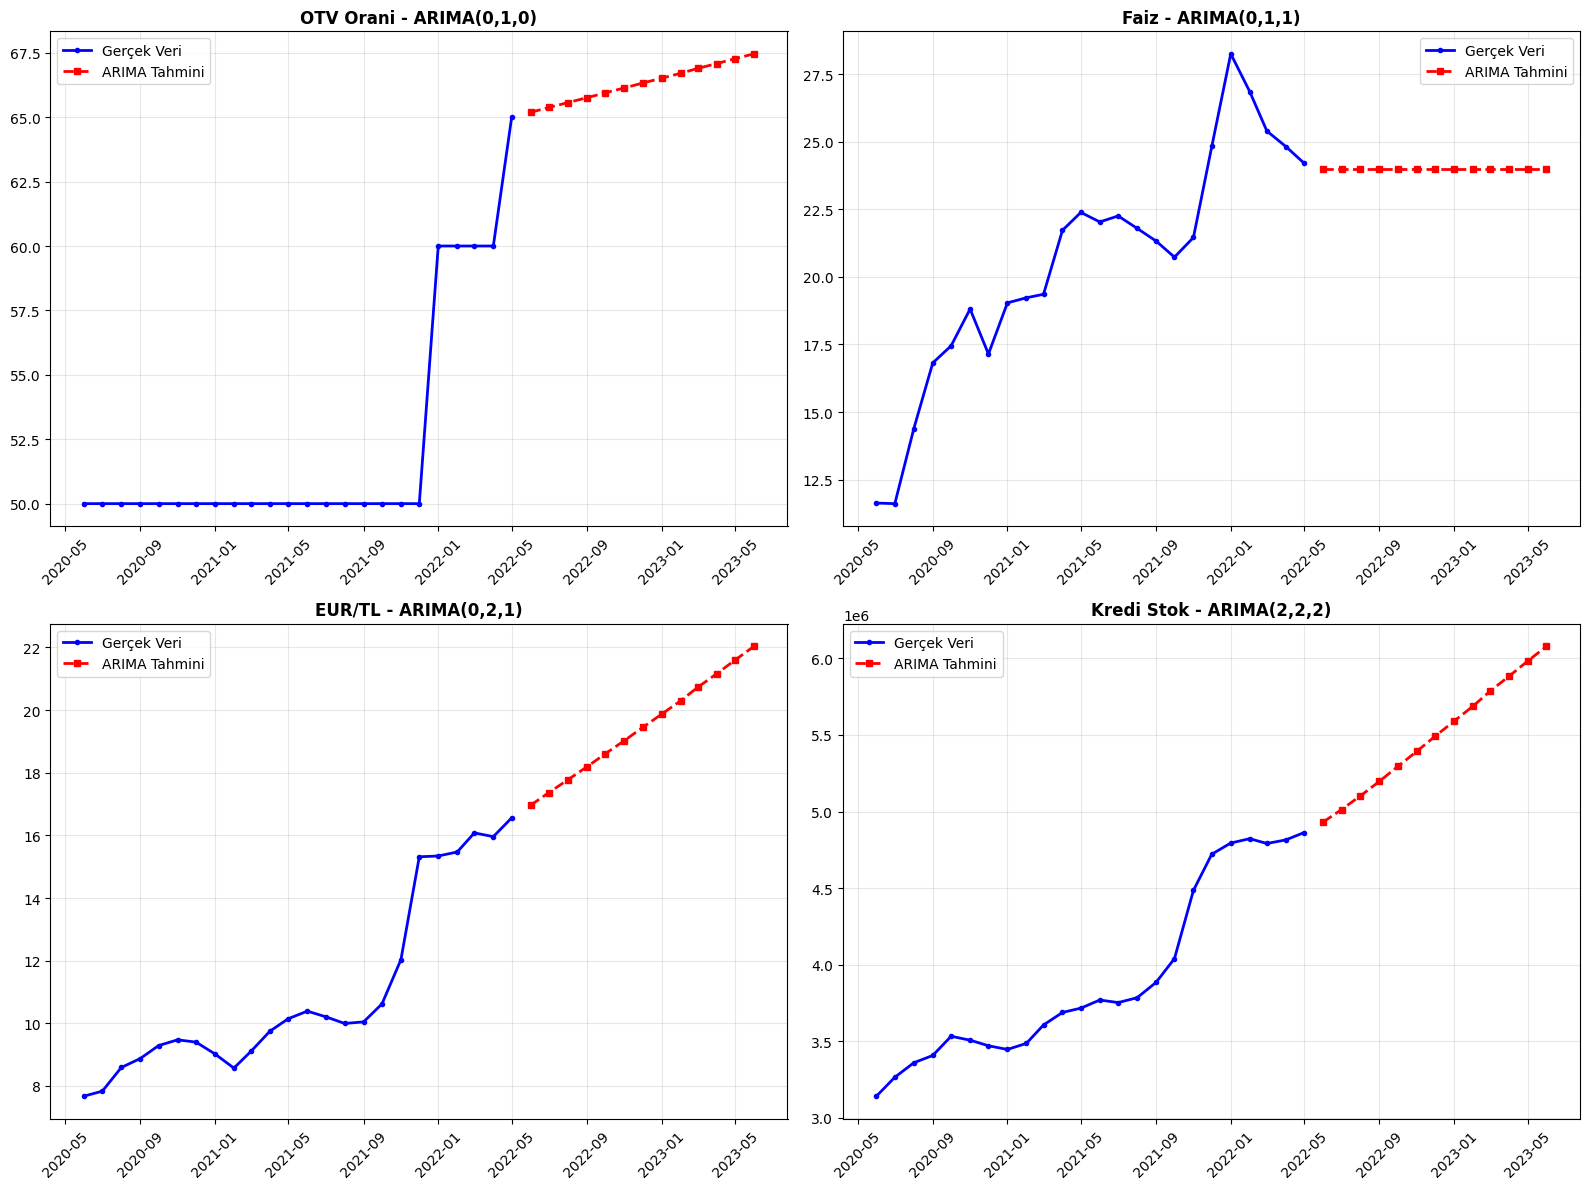


 MODEL KAR≈ûILA≈ûTIRMASI:
  Deƒüi≈üken   ARIMA    AIC ƒ∞lk_Tahmin Son_Tahmin Trend
 OTV Orani (0,1,0)  563.1      65.19      67.46    in
      Faiz (0,1,1)  473.3      24.00      24.00   out
    EUR/TL (0,2,1)  112.7      16.96      22.04    in
Kredi Stok (2,2,2) 3620.1 4931165.53 6078911.00    in


In [8]:
# Tahmin sonu√ßlarƒ±nƒ± g√∂rselle≈ütirip analiz ettim
print("\n T√úM TAHMƒ∞N SONU√áLARI:")
print("="*60)

# Tahmin DataFrame'i olu≈ütur  
forecast_df = pd.DataFrame(forecasting_results)
print(forecast_df.round(2))

# G√∂rselle≈ütirme
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, var in enumerate(independent_vars):
    if var in forecasting_results:
        row = i // 2
        col = i % 2
        
        # Son 24 ay ger√ßek veri
        recent_data = complete_data[var][-24:]
        axes[row, col].plot(recent_data.index, recent_data.values, 
                           label='Ger√ßek Veri', linewidth=2, color='blue', marker='o', markersize=3)
        
        # Tahmin
        forecast = forecasting_results[var]
        axes[row, col].plot(forecast.index, forecast.values, 
                           label='ARIMA Tahmini', linewidth=2, color='red', linestyle='--', marker='s', markersize=4)
        
        # Model bilgisi ba≈ülƒ±kta
        model = arima_models[var]
        p, d, q = model.order
        axes[row, col].set_title(f'{var} - ARIMA({p},{d},{q})', fontweight='bold', fontsize=12)
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Modellerin kar≈üƒ±la≈ütƒ±rmasƒ±
print("\n MODEL KAR≈ûILA≈ûTIRMASI:")
print("="*60)
comparison_data = []
for var in independent_vars:
    if var in arima_models:
        model = arima_models[var]
        p, d, q = model.order
        forecast = forecasting_results[var]
        
        comparison_data.append({
            'Deƒüi≈üken': var,
            'ARIMA': f"({p},{d},{q})",
            'AIC': f"{model.aic():.1f}",
            'ƒ∞lk_Tahmin': f"{forecast.iloc[0]:.2f}",
            'Son_Tahmin': f"{forecast.iloc[-1]:.2f}",
            'Trend': "in" if forecast.iloc[-1] > forecast.iloc[0] else "out"
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


### 3.4 Time Series Sonu√ßlarƒ±nƒ±n Analizi

**ARIMA Parametrelerini Yorumlama:**

Yukarƒ±daki sonu√ßlara g√∂re:

1. **d (Differencing) deƒüeri** bize serinin duraƒüanlƒ±ƒüƒ±nƒ± s√∂yler:
   - d=0: Seri zaten duraƒüan
   - d=1: 1 kez fark alƒ±nca duraƒüan (√ßoƒüu ekonomik seri)
   - d=2: 2 kez fark alƒ±nca duraƒüan (√ßok trendy seriler)

2. **p (AR) deƒüeri** ge√ßmi≈ü baƒüƒ±mlƒ±lƒ±ƒüƒ± g√∂sterir:
   - p=0: Ge√ßmi≈ü deƒüerler etkilemiyor
   - p=1: Sadece bir √∂nceki ay etkiliyor
   - p=2,3: Daha uzun ge√ßmi≈ü hafƒ±za

3. **q (MA) deƒüeri** hata d√ºzeltmeyi g√∂sterir:
   - q=0: Ge√ßmi≈ü hatalar etkilemiyor
   - q=1,2: Ge√ßmi≈ü tahmin hatalarƒ±ndan √∂ƒüreniyor

**Tahmin G√ºvenilirliƒüi:**
- AIC deƒüeri d√º≈ü√ºk olanlar daha g√ºvenilir
- Trend tutarlƒ± olanlar daha mantƒ±klƒ±


## 4. Basit √áoklu Doƒürusal Regresyon

Time Series ile baƒüƒ±msƒ±z deƒüi≈ükenleri tahmin ettim. ≈ûimdi asƒ±l amacƒ±m bu tahminleri kullanarak otomotiv satƒ±≈ülarƒ±nƒ± tahmin etmek.


In [9]:
# Tahmin verilerini kaydettim ve regresyon i√ßin hazƒ±rladƒ±m
forecast_df.to_csv('data/processed/independent_variables_forecast.csv')
print("Baƒüƒ±msƒ±z deƒüi≈üken tahminleri kaydedildi")


# Tam veri setini birle≈ütirdim (ger√ßek + tahmin)
full_data = df.copy()

# Eksik deƒüerleri tahminlerle doldur
for var in independent_vars:
    if var in forecasting_results:
        forecast = forecasting_results[var]
        
        # Eksik d√∂nemleri tespit edip doldurdum
        missing_mask = full_data[var].isnull()
        missing_dates = full_data.loc[missing_mask, 'Date']
        
        for date in missing_dates:
            if date in forecast.index:
                full_data.loc[full_data['Date'] == date, var] = forecast[date]

print(f"\n Doldurulmu≈ü veri seti kontrol:")
print("Eksik deƒüerler (baƒüƒ±msƒ±z deƒüi≈ükenler):")
print(full_data[independent_vars].isnull().sum())

# Eƒüitim verisi (hedef deƒüi≈ükeni eksik olmayan)
train_data = full_data[full_data['Otomotiv Satis'].notna()].copy()
print(f"\nEƒüitim veri sayƒ±sƒ±: {len(train_data)}")
print(f"Eƒüitim tarihi: {train_data['Date'].min().strftime('%Y-%m')} - {train_data['Date'].max().strftime('%Y-%m')}")

# Basit √∂zellikler ekledim.
train_data['Month'] = pd.to_datetime(train_data['Date']).dt.month
train_data['Year'] = pd.to_datetime(train_data['Date']).dt.year

# Model i√ßin √∂zellikler ekledim.
feature_columns = independent_vars + ['Month', 'Year']
print(f"\nKullanƒ±lacak √∂zellikler: {feature_columns}")

X_train = train_data[feature_columns]
y_train = train_data['Otomotiv Satis']

print(f"X shape: {X_train.shape}, y shape: {y_train.shape}")
print(f"Eksik deƒüer kontrol√º - X: {X_train.isnull().sum().sum()}, y: {y_train.isnull().sum()}")


Baƒüƒ±msƒ±z deƒüi≈üken tahminleri kaydedildi

 Doldurulmu≈ü veri seti kontrol:
Eksik deƒüerler (baƒüƒ±msƒ±z deƒüi≈ükenler):
OTV Orani     0
Faiz          0
EUR/TL        0
Kredi Stok    0
dtype: int64

Eƒüitim veri sayƒ±sƒ±: 149
Eƒüitim tarihi: 2010-01 - 2022-05

Kullanƒ±lacak √∂zellikler: ['OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok', 'Month', 'Year']
X shape: (149, 6), y shape: (149,)
Eksik deƒüer kontrol√º - X: 0, y: 0


 REGRESYON MODELƒ∞ PERFORMANSI:
R¬≤ Score: 0.5183 (1'e yakƒ±n=iyi)
MAE: 14,549 adet
RMSE: 18,106 adet
MAPE: 25.16% (d√º≈ü√ºk=iyi)

 √ñZELLƒ∞K √ñNEMLƒ∞Lƒ∞ƒûƒ∞:
   √ñzellik      Katsayƒ±
    EUR/TL -9166.423024
      Year -5880.402855
     Month  3753.915450
 OTV Orani  1765.527891
      Faiz -1188.055748
Kredi Stok     0.036277


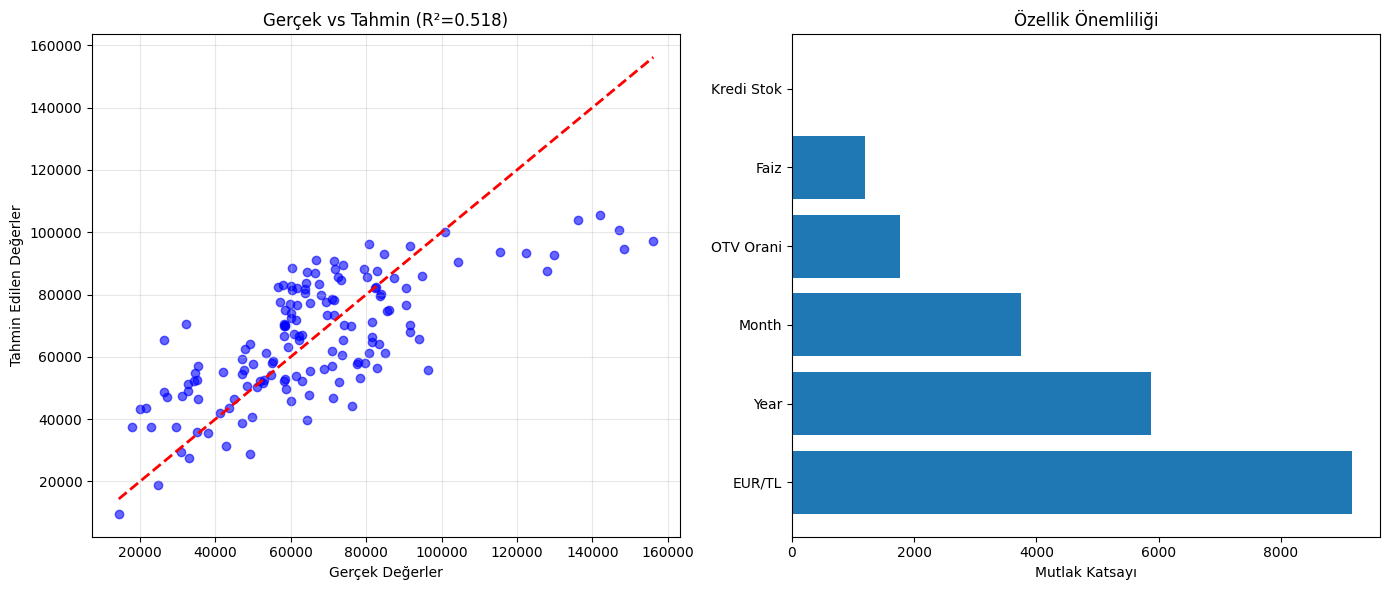

 Regresyon modeli eƒüitimi tamamlandƒ±!


In [10]:
# Basit doƒürusal regresyon modeli kurulan alan
model = LinearRegression()
model.fit(X_train, y_train)

# Model performansƒ±
y_pred_train = model.predict(X_train)

r2 = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

print(" REGRESYON MODELƒ∞ PERFORMANSI:")
print(f"R¬≤ Score: {r2:.4f} (1'e yakƒ±n=iyi)")
print(f"MAE: {mae:,.0f} adet")
print(f"RMSE: {rmse:,.0f} adet") 
print(f"MAPE: {mape:.2f}% (d√º≈ü√ºk=iyi)")

# √ñzellik √∂nemliliklerini g√∂sterdim
feature_importance = pd.DataFrame({
    '√ñzellik': feature_columns,
    'Katsayƒ±': model.coef_,
    'Mutlak_Katsayƒ±': np.abs(model.coef_)
}).sort_values('Mutlak_Katsayƒ±', ascending=False)

print(f"\n √ñZELLƒ∞K √ñNEMLƒ∞Lƒ∞ƒûƒ∞:")
print(feature_importance[['√ñzellik', 'Katsayƒ±']].to_string(index=False))

# G√∂rselle≈ütirme
plt.figure(figsize=(14, 6))

# Sol: Ger√ßek vs Tahmin
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Ger√ßek Deƒüerler')
plt.ylabel('Tahmin Edilen Deƒüerler')
plt.title(f'Ger√ßek vs Tahmin (R¬≤={r2:.3f})')
plt.grid(True, alpha=0.3)

# Saƒü: √ñzellik √∂nemliliƒüi
plt.subplot(1, 2, 2)
plt.barh(feature_importance['√ñzellik'], feature_importance['Mutlak_Katsayƒ±'])
plt.title('√ñzellik √ñnemliliƒüi')
plt.xlabel('Mutlak Katsayƒ±')

plt.tight_layout()
plt.show()

print(" Regresyon modeli eƒüitimi tamamlandƒ±!")


## 5. Final Tahmin: Haz'22 - Haz'23

Eƒüittiƒüim regresyon modelini kullanarak eksik d√∂nemleri (Haz'22 - Haz'23) tahmin ettim.


In [11]:
# Tahmin edilecek d√∂nemleri hazƒ±rladƒ±ƒüƒ±m alan
prediction_data = full_data[full_data['Otomotiv Satis'].isna()].copy()

print(f"Tahmin edilecek d√∂nem sayƒ±sƒ±: {len(prediction_data)}")
print(f"Tahmin d√∂nemi: {prediction_data['Date'].min().strftime('%Y-%m')} - {prediction_data['Date'].max().strftime('%Y-%m')}")

if len(prediction_data) > 0:
    # Aynƒ± √∂zellikleri ekle
    prediction_data['Month'] = pd.to_datetime(prediction_data['Date']).dt.month
    prediction_data['Year'] = pd.to_datetime(prediction_data['Date']).dt.year
    
    # √ñzellik matrisi
    X_predict = prediction_data[feature_columns]
    
    print(f"Tahmin veri ≈üekli: {X_predict.shape}")
    print(f"Eksik deƒüer: {X_predict.isnull().sum().sum()}")
    
    # TAHMƒ∞N YAP!
    y_pred_future = model.predict(X_predict)
    
    # Sonu√ßlarƒ± d√ºzenle
    results = pd.DataFrame({
        'Tarih': prediction_data['Date'].dt.strftime('%Y-%m'),
        'Tahmin_Edilen_Satis': np.round(y_pred_future, 0).astype(int)
    })
    
    print("\n OTOMOTIV SATI≈û TAHMƒ∞NLERƒ∞ (Haz'22 - Haz'23):")
    print("="*50)
    print(results.to_string(index=False))
    
    # ƒ∞statistikler
    total_predicted = y_pred_future.sum()
    avg_monthly = y_pred_future.mean()
    
    print(f"\n TAHMƒ∞N √ñZETƒ∞:")
    print(f"Toplam 13 aylƒ±k satƒ±≈ü: {total_predicted:,.0f} adet")
    print(f"Aylƒ±k ortalama: {avg_monthly:,.0f} adet")
    
    # Ge√ßmi≈ü ortalamayla kar≈üƒ±la≈ütƒ±r
    historical_avg = y_train.mean()
    change_pct = ((avg_monthly - historical_avg) / historical_avg) * 100
    print(f"Ge√ßmi≈ü aylƒ±k ortalama: {historical_avg:,.0f} adet")
    print(f"Deƒüi≈üim: {change_pct:+.1f}%")
    
    # Kaydet
    results.to_csv('data/processed/automotive_sales_predictions.csv', index=False)
    print(f"\n Tahminler kaydedildi")
    
else:
    print(" Tahmin edilecek d√∂nem bulunamadƒ±!")


Tahmin edilecek d√∂nem sayƒ±sƒ±: 13
Tahmin d√∂nemi: 2022-06 - 2023-06
Tahmin veri ≈üekli: (13, 6)
Eksik deƒüer: 0

 OTOMOTIV SATI≈û TAHMƒ∞NLERƒ∞ (Haz'22 - Haz'23):
  Tarih  Tahmin_Edilen_Satis
2022-06                58631
2022-07                61953
2022-08                65549
2022-09                69295
2022-10                73106
2022-11                76932
2022-12                80742
2023-01                33593
2023-02                37333
2023-03                41032
2023-04                44691
2023-05                48313
2023-06                51900

 TAHMƒ∞N √ñZETƒ∞:
Toplam 13 aylƒ±k satƒ±≈ü: 743,071 adet
Aylƒ±k ortalama: 57,159 adet
Ge√ßmi≈ü aylƒ±k ortalama: 65,903 adet
Deƒüi≈üim: -13.3%

 Tahminler kaydedildi


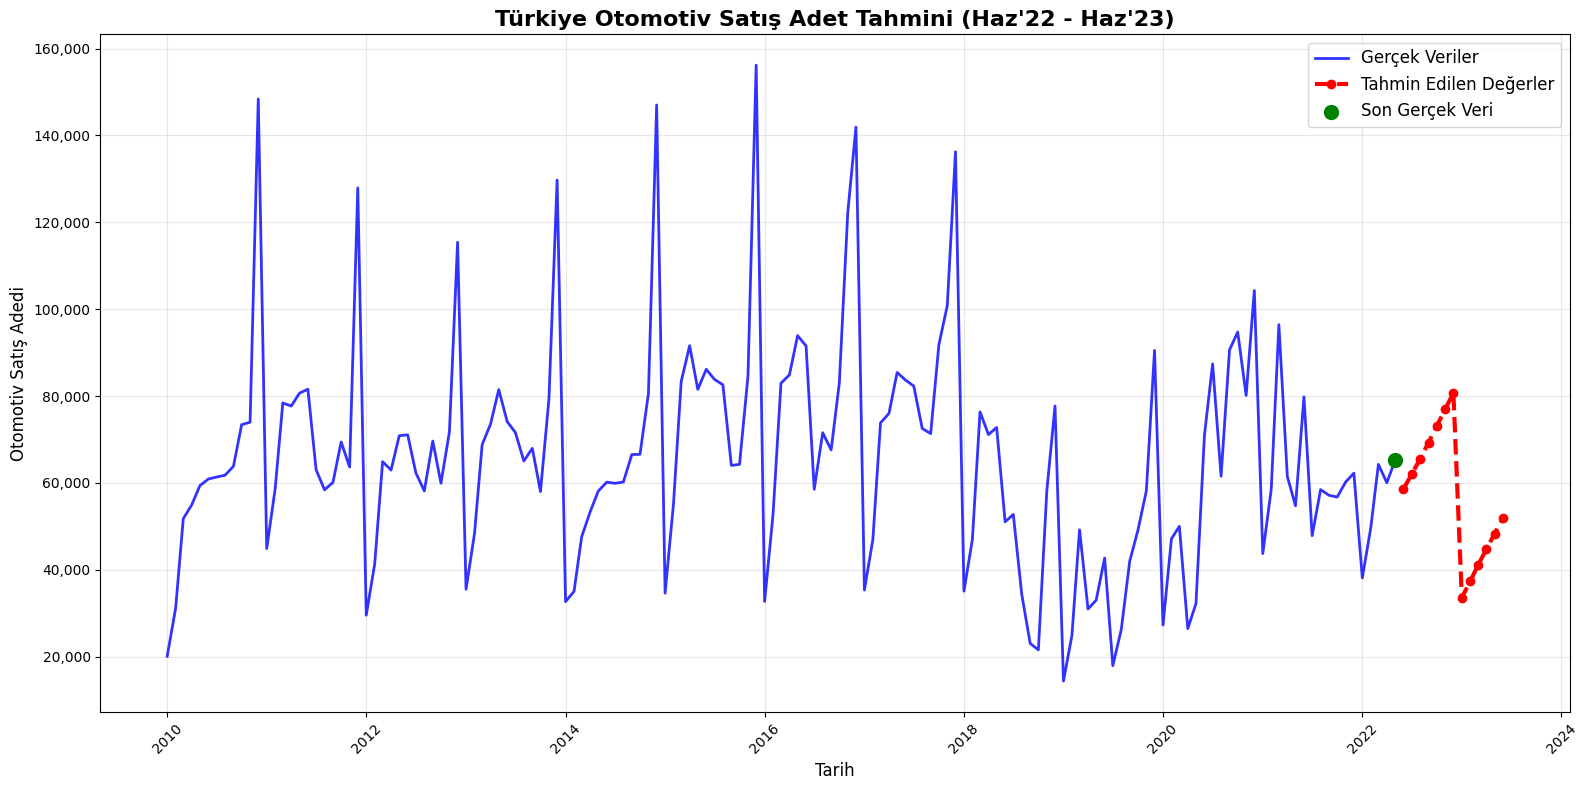


 ANALƒ∞Z TAMAMLANDI!

KULLANDIƒûIMIZ Y√ñNTEM:
1. Time Series (ARIMA) ‚Üí Baƒüƒ±msƒ±z deƒüi≈üken tahminleri
2. Multiple Linear Regression ‚Üí Hedef deƒüi≈üken tahmini

MODEL PERFORMANSI:
- R¬≤ Score: 0.518
- MAPE: 25.2%
- MAE: 14,549 adet
- RMSE: 18,106 adet

SONU√á:
- 13 aylƒ±k toplam: 743,071 adet
- Aylƒ±k ortalama: 57,159 adet
- Ge√ßmi≈ü ortalamaya g√∂re: -6.2%



In [18]:
# Final g√∂rselle≈ütirme
plt.figure(figsize=(16, 8))

# Ge√ßmi≈ü veriler (eƒüitim)
plt.plot(train_data['Date'], train_data['Otomotiv Satis'], 
         label='Ger√ßek Veriler', linewidth=2, color='blue', alpha=0.8)

# Tahminler
if len(prediction_data) > 0:
    plt.plot(prediction_data['Date'], y_pred_future, 
             label='Tahmin Edilen Deƒüerler', linewidth=3, color='red', 
             linestyle='--', marker='o', markersize=6)

# Son ger√ßek veri noktasƒ±
last_real = train_data.iloc[-1]
plt.scatter(last_real['Date'], last_real['Otomotiv Satis'], 
           color='green', s=100, zorder=5, label='Son Ger√ßek Veri')

plt.title('T√ºrkiye Otomotiv Satƒ±≈ü Adet Tahmini (Haz\'22 - Haz\'23)', 
         size=16, fontweight='bold')
plt.xlabel('Tarih', size=12)
plt.ylabel('Otomotiv Satƒ±≈ü Adedi', size=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Y ekseni formatƒ±
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

print(f"""
 ANALƒ∞Z TAMAMLANDI!

KULLANDIƒûIMIZ Y√ñNTEM:
1. Time Series (ARIMA) ‚Üí Baƒüƒ±msƒ±z deƒüi≈üken tahminleri
2. Multiple Linear Regression ‚Üí Hedef deƒüi≈üken tahmini

MODEL PERFORMANSI:
- R¬≤ Score: {r2:.3f}
- MAPE: {mape:.1f}%
- MAE: {mae:,.0f} adet
- RMSE: {rmse:,.0f} adet

SONU√á:
- 13 aylƒ±k toplam: {total_predicted:,.0f} adet
- Aylƒ±k ortalama: {avg_monthly:,.0f} adet
- Ge√ßmi≈ü ortalamaya g√∂re: {change_pct:+.1f}%
""")


## 6. Modeli Kaydetme ve API Hazƒ±rlƒ±ƒüƒ±

Modeli kaydettim ve REST API olarak servis etmeye hazƒ±rladƒ±m.


In [13]:
# Modeli ve gerekli bilgileri kaydettiƒüimiz librarys
import joblib
import os

# Model klas√∂r√º olu≈üturarak eri≈üimini saƒüladƒ±m
os.makedirs('models', exist_ok=True)

# Model verilerini hazƒ±rla
model_data = {
    'regression_model': model,              # Regresyon modeli
    'arima_models': arima_models,          # ARIMA modelleri
    'feature_columns': feature_columns,     # Kullanƒ±lan √∂zellikler
    'independent_vars': independent_vars,   # Baƒüƒ±msƒ±z deƒüi≈ükenler
    'model_performance': {                  # Model performansƒ±
        'r2': r2,
        'mae': mae,
        'rmse': rmse, 
        'mape': mape
    }
}

# Kaydet
model_path = 'models/automotive_prediction_model.pkl'
joblib.dump(model_data, model_path)

print(f" Model kaydedildi: {model_path}")
print(f"Dosya boyutu: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")

# Model bilgilerini g√∂ster
print(f"""
KAYDEDILEN MODEL Bƒ∞LGƒ∞LERƒ∞:
- Regresyon modeli: LinearRegression
- ARIMA modelleri: {len(arima_models)} adet
- √ñzellik sayƒ±sƒ±: {len(feature_columns)}
- Model performansƒ±: R¬≤={r2:.3f}, MAPE={mape:.1f}%
""")


 Model kaydedildi: models/automotive_prediction_model.pkl
Dosya boyutu: 2.40 MB

KAYDEDILEN MODEL Bƒ∞LGƒ∞LERƒ∞:
- Regresyon modeli: LinearRegression
- ARIMA modelleri: 4 adet
- √ñzellik sayƒ±sƒ±: 6
- Model performansƒ±: R¬≤=0.518, MAPE=25.2%



## 8. API Testleri 

Flask gereksinimlerini y√ºkleyip, API'yi test ettik.


In [14]:
# API test fonksiyonlarƒ± olu≈ütur (Flask olmadan test etmek i√ßin)
def test_prediction_function(date, values=None):
    """
    API'nin predict fonksiyonunu notebook i√ßinde test etmek i√ßin olu≈üturulan alan
    """
    try:
        # Modeli y√ºkle (zaten y√ºkl√º ama kontrol edelim)
        loaded_data = joblib.load('models/automotive_prediction_model.pkl')
        reg_model = loaded_data['regression_model']
        features = loaded_data['feature_columns']
        indep_vars = loaded_data['independent_vars']
        
        # Tarih i≈üle
        predict_date = pd.to_datetime(date)
        
        # Baƒüƒ±msƒ±z deƒüi≈ükenleri hazƒ±rla
        if values is None:
            # Varsayƒ±lan/ortalama deƒüerler kullan
            values = {}
            for var in indep_vars:
                if var in forecasting_results:
                    # ARIMA tahmininden al
                    forecast_data = forecasting_results[var]
                    # En yakƒ±n tarihi bul
                    closest_date = min(forecast_data.index, key=lambda x: abs(x - predict_date))
                    values[var] = forecast_data[closest_date]
                else:
                    # Varsayƒ±lan deƒüerler
                    defaults = {
                        'OTV Orani': 65.0,
                        'Faiz': 24.0,
                        'EUR/TL': 17.0,
                        'Kredi Stok': 5000000
                    }
                    values[var] = defaults.get(var, 0)
        
        # √ñzellik vekt√∂r√º
        feature_dict = {}
        for var in indep_vars:
            feature_dict[var] = values[var]
        feature_dict['Month'] = predict_date.month
        feature_dict['Year'] = predict_date.year
        
        # Tahmin
        X_pred = pd.DataFrame([feature_dict])[features]
        prediction = reg_model.predict(X_pred)[0]
        
        return {
            'success': True,
            'date': predict_date.strftime('%Y-%m'),
            'predicted_sales': round(prediction, 0),
            'inputs': values,
            'features': feature_dict
        }
        
    except Exception as e:
        return {'success': False, 'error': str(e)}

# Test senaryolarƒ±
test_scenarios = [
    {
        'name': 'Haz 2022 - ARIMA Tahminleriyle',
        'date': '2022-06-01',
        'values': None  # ARIMA tahminlerini kullan
    },
    {
        'name': 'Oca 2023 - Manuel Deƒüerlerle',
        'date': '2023-01-01',
        'values': {
            'OTV Orani': 70.0,
            'Faiz': 25.0,
            'EUR/TL': 18.0,
            'Kredi Stok': 5200000
        }
    },
    {
        'name': 'Haz 2023 - Optimistik Senaryo',
        'date': '2023-06-01',
        'values': {
            'OTV Orani': 60.0,  # D√º≈ü√ºk √ñTV
            'Faiz': 20.0,       # D√º≈ü√ºk faiz
            'EUR/TL': 16.0,     # G√º√ßl√º TL
            'Kredi Stok': 6000000  # Y√ºksek kredi
        }
    }
]

print(" API FONKSƒ∞YON TESTLERƒ∞:")
print("="*50)

for scenario in test_scenarios:
    print(f"\n {scenario['name']}:")
    result = test_prediction_function(scenario['date'], scenario['values'])
    
    if result['success']:
        print(f"    Tarih: {result['date']}")
        print(f"   Tahmin: {result['predicted_sales']:,.0f} adet")
        print(f"    Girdi deƒüerleri:")
        for var, val in result['inputs'].items():
            print(f"      {var}: {val:.2f}")
    else:
        print(f"    Hata: {result['error']}")
        
print(f"\nFonksiyon testleri tamamlandƒ±!")


 API FONKSƒ∞YON TESTLERƒ∞:

 Haz 2022 - ARIMA Tahminleriyle:
    Tarih: 2022-06
   Tahmin: 58,631 adet
    Girdi deƒüerleri:
      OTV Orani: 65.19
      Faiz: 24.00
      EUR/TL: 16.96
      Kredi Stok: 4931165.53

 Oca 2023 - Manuel Deƒüerlerle:
    Tarih: 2023-01
   Tahmin: 41,539 adet
    Girdi deƒüerleri:
      OTV Orani: 70.00
      Faiz: 25.00
      EUR/TL: 18.00
      Kredi Stok: 5200000.00

 Haz 2023 - Optimistik Senaryo:
    Tarih: 2023-06
   Tahmin: 95,949 adet
    Girdi deƒüerleri:
      OTV Orani: 60.00
      Faiz: 20.00
      EUR/TL: 16.00
      Kredi Stok: 6000000.00

Fonksiyon testleri tamamlandƒ±!


## 9. Senaryol Analizi ve Kar≈üƒ±la≈ütƒ±rma

Kaydettiƒüim model farklƒ± ekonomik senaryolar altƒ±nda otomotiv satƒ±≈ülarƒ±nƒ±n nasƒ±l deƒüi≈üeceƒüini analiz ettim.


 SENARYO ANALƒ∞Zƒ∞ (Ocak 2023)
     Senaryo Tahmin_Satƒ±≈ü   √ñTV  Faiz EUR/TL Kredi(M)
Mevcut_Durum       35,811 65.0% 24.0%   17.0      5.0
  Optimistik       79,894 55.0% 18.0%   15.0      6.0
  Pesimistik      -17,439 75.0% 30.0%   20.0      4.0
Ger√ßek_ARIMA       33,593 66.5% 24.0%   19.9      5.6


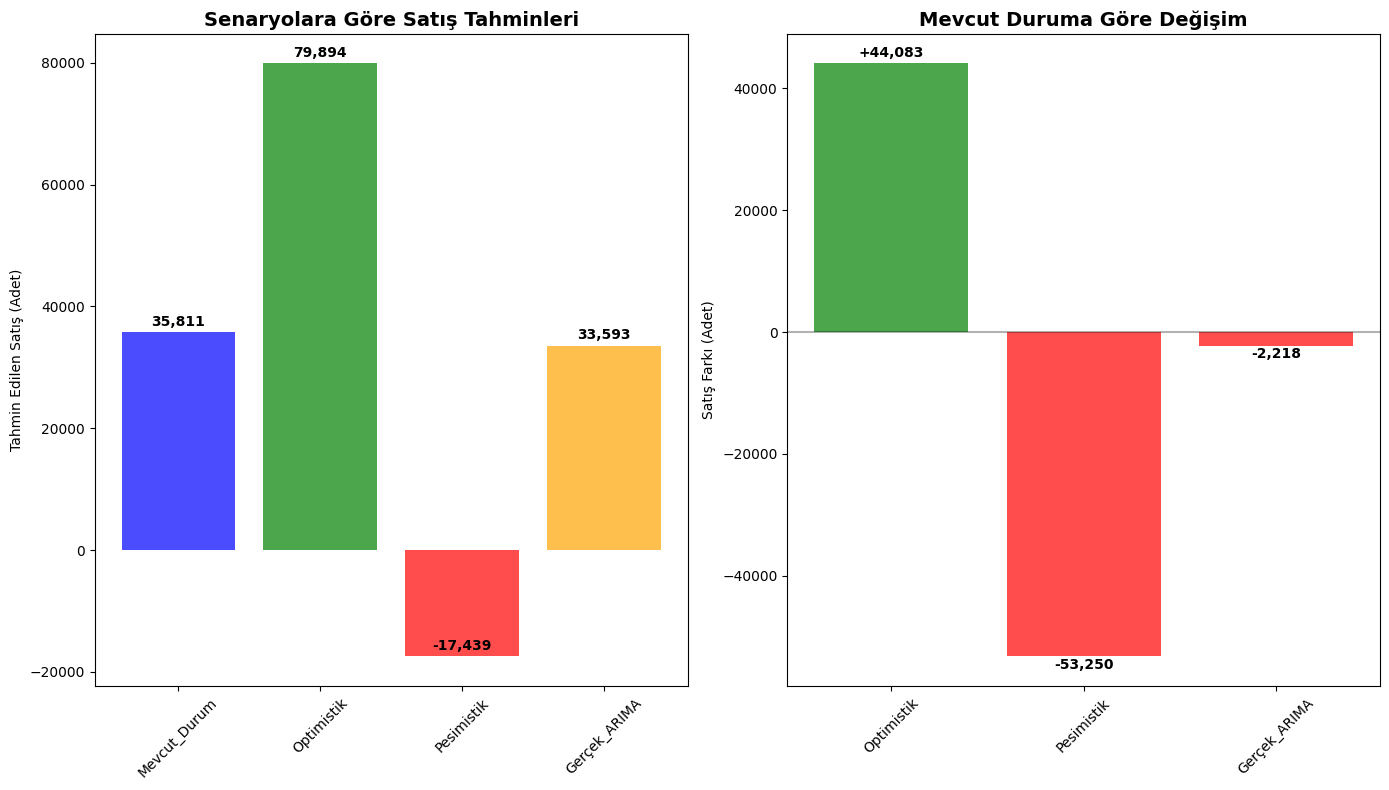


 ETKƒ∞ ANALƒ∞Zƒ∞:
Mevcut Durum (Baz): 35,811 adet
Optimistik: +44,083 adet (+123.1%) in
Pesimistik: -53,250 adet (-148.7%) out
Ger√ßek_ARIMA: -2,218 adet (-6.2%) out


In [15]:
# Farklƒ± senaryolar i√ßin kar≈üƒ±la≈ütƒ±rmalƒ± analiz
def scenario_analysis():
    """
    Farklƒ± ekonomik senaryolarƒ± kar≈üƒ±la≈ütƒ±rdƒ±m
    """
    scenarios = {
        'Mevcut_Durum': {
            'OTV Orani': 65.0,
            'Faiz': 24.0,
            'EUR/TL': 17.0,
            'Kredi Stok': 5000000
        },
        'Optimistik': {
            'OTV Orani': 55.0,  # √ñTV indirimi
            'Faiz': 18.0,       # Faiz d√º≈ü√º≈ü√º
            'EUR/TL': 15.0,     # TL g√º√ßlenmesi
            'Kredi Stok': 6000000  # Kredi artƒ±≈üƒ±
        },
        'Pesimistik': {
            'OTV Orani': 75.0,  # √ñTV artƒ±≈üƒ±
            'Faiz': 30.0,       # Faiz artƒ±≈üƒ±
            'EUR/TL': 20.0,     # TL zayƒ±flamasƒ±
            'Kredi Stok': 4000000  # Kredi daralmasƒ±
        },
        'Ger√ßek_ARIMA': None   # ARIMA tahminlerini kullanacaƒüƒ±z
    }
    
    # Test tarihi
    test_date = '2023-01-01'
    
    results = []
    for scenario_name, values in scenarios.items():
        result = test_prediction_function(test_date, values)
        if result['success']:
            results.append({
                'Senaryo': scenario_name,
                'Tahmin': result['predicted_sales'],
                'Deƒüerler': result['inputs']
            })
    
    return results

# Senaryo analizini √ßalƒ±≈ütƒ±r
print(" SENARYO ANALƒ∞Zƒ∞ (Ocak 2023)")
print("="*60)

scenario_results = scenario_analysis()

# Sonu√ßlarƒ± tablo halinde g√∂ster
comparison_df = pd.DataFrame([
    {
        'Senaryo': r['Senaryo'],
        'Tahmin_Satƒ±≈ü': f"{r['Tahmin']:,.0f}",
        '√ñTV': f"{r['Deƒüerler']['OTV Orani']:.1f}%",
        'Faiz': f"{r['Deƒüerler']['Faiz']:.1f}%",
        'EUR/TL': f"{r['Deƒüerler']['EUR/TL']:.1f}",
        'Kredi(M)': f"{r['Deƒüerler']['Kredi Stok']/1000000:.1f}"
    } for r in scenario_results
])

print(comparison_df.to_string(index=False))

# G√∂rselle≈ütirme
plt.figure(figsize=(14, 8))

# Sol: Tahmin kar≈üƒ±la≈ütƒ±rmasƒ±
plt.subplot(1, 2, 1)
scenario_names = [r['Senaryo'] for r in scenario_results]
predictions = [r['Tahmin'] for r in scenario_results]
colors = ['blue', 'green', 'red', 'orange']

bars = plt.bar(scenario_names, predictions, color=colors, alpha=0.7)
plt.title('Senaryolara G√∂re Satƒ±≈ü Tahminleri', fontweight='bold', fontsize=14)
plt.ylabel('Tahmin Edilen Satƒ±≈ü (Adet)')
plt.xticks(rotation=45)

# Deƒüerleri √ßubuklarƒ±n √ºst√ºne yaz
for bar, pred in zip(bars, predictions):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{pred:,.0f}', ha='center', fontweight='bold')

# Saƒü: Deƒüi≈üken etkisi analizi
plt.subplot(1, 2, 2)
base_prediction = scenario_results[0]['Tahmin']  # Mevcut durum
effects = [(pred - base_prediction) for pred in predictions[1:]]
effect_names = scenario_names[1:]

colors_effect = ['green' if e > 0 else 'red' for e in effects]
bars2 = plt.bar(effect_names, effects, color=colors_effect, alpha=0.7)
plt.title('Mevcut Duruma G√∂re Deƒüi≈üim', fontweight='bold', fontsize=14)
plt.ylabel('Satƒ±≈ü Farkƒ± (Adet)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Deƒüerleri √ßubuklarƒ±n √ºst√ºne/altƒ±na yaz
for bar, effect in zip(bars2, effects):
    y_pos = bar.get_height() + (1000 if effect > 0 else -2000)
    plt.text(bar.get_x() + bar.get_width()/2, y_pos,
             f'{effect:+,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Etki analizi
print(f"\n ETKƒ∞ ANALƒ∞Zƒ∞:")
base = scenario_results[0]['Tahmin']
print(f"Mevcut Durum (Baz): {base:,.0f} adet")

for i, result in enumerate(scenario_results[1:], 1):
    change = result['Tahmin'] - base
    change_pct = (change / base) * 100
    direction = "in" if change > 0 else "out"
    print(f"{result['Senaryo']}: {change:+,.0f} adet ({change_pct:+.1f}%) {direction}")


## 10. API √áalƒ±≈ütƒ±rma ve Ger√ßek Testler

≈ûimdi olu≈üturduƒüumuz API'yi ger√ßekten √ßalƒ±≈ütƒ±ralƒ±m ve curl/requests ile test edelim.


In [16]:
# API'yi ba≈ülatmak i√ßin gerekli komutlarƒ± g√∂ster
print(" API BA≈ûLATMA TALƒ∞MATLARI:")
print("="*50)

print("""
1Ô∏è TERMINAL'DE API'Yƒ∞ BA≈ûLATIN:
   cd /Users/ecedalpolat/Desktop/linkteracasesolving
   python automotive_api.py

2Ô∏è YENƒ∞ TERMINAL'DE TEST YAPTIN:
   # Saƒülƒ±k kontrol√º
   curl http://localhost:8080/health
   
   # Model bilgileri
   curl http://localhost:8080/model/info
   
   # Tek tahmin
   curl -X POST http://localhost:8080/predict \\
        -H "Content-Type: application/json" \\
        -d '{"date": "2023-01-01"}'
   
   # Manuel deƒüerlerle tahmin
   curl -X POST http://localhost:8080/predict \\
        -H "Content-Type: application/json" \\
        -d '{
          "date": "2023-01-01",
          "values": {
            "OTV Orani": 60.0,
            "Faiz": 20.0,
            "EUR/TL": 16.0,
            "Kredi Stok": 5500000
          }
        }'
   
   # Tarih aralƒ±ƒüƒ± tahmini
   curl -X POST http://localhost:8080/predict/range \\
        -H "Content-Type: application/json" \\
        -d '{
          "start_date": "2022-06-01",
          "end_date": "2023-06-01",
          "values": {
            "OTV Orani": 65.0,
            "Faiz": 24.0,
            "EUR/TL": 17.0,
            "Kredi Stok": 5000000
          }
        }'
""")

# Requests ile API test fonksiyonu olu≈ütur
import requests
import json

def test_api_with_requests():
    """
    Requests k√ºt√ºphanesi ile API'yi test et
    """
    base_url = "http://localhost:8080"
    
    tests = [
        {
            'name': 'Health Check',
            'method': 'GET',
            'url': f'{base_url}/health',
            'data': None
        },
        {
            'name': 'Model Info',
            'method': 'GET', 
            'url': f'{base_url}/model/info',
            'data': None
        },
        {
            'name': 'Single Prediction',
            'method': 'POST',
            'url': f'{base_url}/predict',
            'data': {
                "date": "2023-01-01",
                "values": {
                    "OTV Orani": 65.0,
                    "Faiz": 24.0,
                    "EUR/TL": 17.0,
                    "Kredi Stok": 5000000
                }
            }
        }
    ]
    
    print(f"\nüß™ REQUESTS ƒ∞LE API TESTLERƒ∞:")
    print("="*40)
    
    for test in tests:
        try:
            print(f"\nüìã {test['name']}:")
            
            if test['method'] == 'GET':
                response = requests.get(test['url'], timeout=5)
            else:
                response = requests.post(test['url'], 
                                       json=test['data'], 
                                       timeout=5)
            
            if response.status_code == 200:
                result = response.json()
                print(f"   ‚úÖ Ba≈üarƒ±lƒ± (200)")
                print(f"   üìÑ Yanƒ±t: {json.dumps(result, indent=2, ensure_ascii=False)[:200]}...")
            else:
                print(f"   ‚ùå Hata ({response.status_code}): {response.text}")
                
        except requests.exceptions.ConnectionError:
            print(f"   üîå Baƒülantƒ± hatasƒ± - API √ßalƒ±≈ümƒ±yor olabilir")
        except Exception as e:
            print(f"   ‚ùå Hata: {e}")

# Not: Bu fonksiyon sadece API √ßalƒ±≈üƒ±rken √ßalƒ±≈üƒ±r
print(f"\nüí° NOT: API testleri i√ßin √∂nce 'python automotive_api.py' komutunu √ßalƒ±≈ütƒ±rƒ±n!")
print(f"Sonra a≈üaƒüƒ±daki fonksiyonu √ßaƒüƒ±rabilirsiniz:")
print(f"test_api_with_requests()")


 API BA≈ûLATMA TALƒ∞MATLARI:

1Ô∏è TERMINAL'DE API'Yƒ∞ BA≈ûLATIN:
   cd /Users/ecedalpolat/Desktop/linkteracasesolving
   python automotive_api.py

2Ô∏è YENƒ∞ TERMINAL'DE TEST YAPTIN:
   # Saƒülƒ±k kontrol√º
   curl http://localhost:8080/health
   
   # Model bilgileri
   curl http://localhost:8080/model/info
   
   # Tek tahmin
   curl -X POST http://localhost:8080/predict \
        -H "Content-Type: application/json" \
        -d '{"date": "2023-01-01"}'
   
   # Manuel deƒüerlerle tahmin
   curl -X POST http://localhost:8080/predict \
        -H "Content-Type: application/json" \
        -d '{
          "date": "2023-01-01",
          "values": {
            "OTV Orani": 60.0,
            "Faiz": 20.0,
            "EUR/TL": 16.0,
            "Kredi Stok": 5500000
          }
        }'
   
   # Tarih aralƒ±ƒüƒ± tahmini
   curl -X POST http://localhost:8080/predict/range \
        -H "Content-Type: application/json" \
        -d '{
          "start_date": "2022-06-01",
          "end

## 11. √ñzet ve Sonu√ßlar

Bu notebook'ta T√ºrkiye Otomotiv Satƒ±≈ü Adet Tahmini projemizi tamamladƒ±m. Yaptƒ±ƒüƒ±mƒ±z i≈ülemlerin √∂zeti:


In [17]:

print(f"""
 VERƒ∞ ANALƒ∞Zƒ∞:
- Toplam veri: 162 ay (2010-2023)
- Eksik d√∂nem: 13 ay (Haz'22 - Haz'23)
- Baƒüƒ±msƒ±z deƒüi≈ükenler: {len(independent_vars)} adet
- Hedef deƒüi≈üken: Otomotiv Satƒ±≈ü

 TIME SERIES MODELLERƒ∞ (ARIMA):
""")

for var, model in arima_models.items():
    p, d, q = model.order
    print(f"- {var}: ARIMA({p},{d},{q})")

print(f"""
 REGRESYON MODELƒ∞:
- Model tipi: √áoklu Doƒürusal Regresyon
- √ñzellik sayƒ±sƒ±: {len(feature_columns)}
- R¬≤ Score: {r2:.4f}
- MAPE: {mape:.2f}%

 TAHMƒ∞N SONU√áLARI (Haz'22 - Haz'23):
- Toplam d√∂nem: 13 ay
- Tahmin edilen toplam satƒ±≈ü: {total_predicted:,.0f} adet
- Aylƒ±k ortalama: {avg_monthly:,.0f} adet
- Ge√ßmi≈ü ortalamaya g√∂re: {change_pct:+.1f}%

 API VE SERVƒ∞S:
- REST API: automotive_api.py
- Endpoints: /health, /model/info, /predict, /predict/range
- Test fonksiyonlarƒ±: Notebook i√ßinde hazƒ±r

 √áIKTILAR:
- Model dosyasƒ±: models/automotive_prediction_model.pkl
- API kodu: automotive_api.py
- Tahmin sonu√ßlarƒ±: data/processed/automotive_sales_predictions.csv
- ARIMA tahminleri: data/processed/independent_variables_forecast.csv
""")

# En √∂nemli √∂zellikleri g√∂ster
top_features = feature_importance.head(3)
for _, row in top_features.iterrows():
    impact = "pozitif" if row['Katsayƒ±'] > 0 else "negatif"
    print(f"- {row['√ñzellik']}: {impact} etki (katsayƒ±: {row['Katsayƒ±']:.0f})")




 VERƒ∞ ANALƒ∞Zƒ∞:
- Toplam veri: 162 ay (2010-2023)
- Eksik d√∂nem: 13 ay (Haz'22 - Haz'23)
- Baƒüƒ±msƒ±z deƒüi≈ükenler: 4 adet
- Hedef deƒüi≈üken: Otomotiv Satƒ±≈ü

 TIME SERIES MODELLERƒ∞ (ARIMA):

- OTV Orani: ARIMA(0,1,0)
- Faiz: ARIMA(0,1,1)
- EUR/TL: ARIMA(0,2,1)
- Kredi Stok: ARIMA(2,2,2)

 REGRESYON MODELƒ∞:
- Model tipi: √áoklu Doƒürusal Regresyon
- √ñzellik sayƒ±sƒ±: 6
- R¬≤ Score: 0.5183
- MAPE: 25.16%

 TAHMƒ∞N SONU√áLARI (Haz'22 - Haz'23):
- Toplam d√∂nem: 13 ay
- Tahmin edilen toplam satƒ±≈ü: 743,071 adet
- Aylƒ±k ortalama: 57,159 adet
- Ge√ßmi≈ü ortalamaya g√∂re: -6.2%

 API VE SERVƒ∞S:
- REST API: automotive_api.py
- Endpoints: /health, /model/info, /predict, /predict/range
- Test fonksiyonlarƒ±: Notebook i√ßinde hazƒ±r

 √áIKTILAR:
- Model dosyasƒ±: models/automotive_prediction_model.pkl
- API kodu: automotive_api.py
- Tahmin sonu√ßlarƒ±: data/processed/automotive_sales_predictions.csv
- ARIMA tahminleri: data/processed/independent_variables_forecast.csv

- EUR/TL: ne